In [1]:
import geopandas as gpd
import pandas as pd
import routingpy as rp
import numpy as np
import time
from matplotlib import pyplot as plt
import h3
import warnings
warnings.filterwarnings("ignore")  # Silence some warnings

https://routingpy.readthedocs.io/en/latest/#valhalla

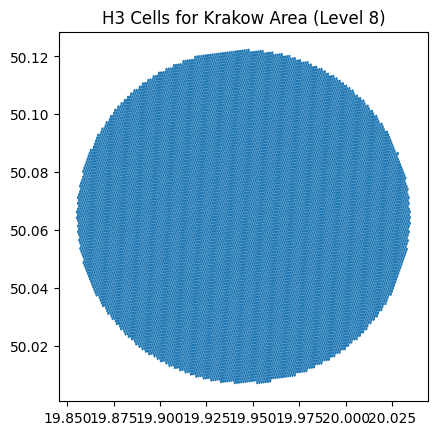

In [2]:
import geopandas as gpd
import h3
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt

# Define Krakow's coordinates and buffer
krakow_coords = (19.9449799, 50.0646501)  # Coordinates of Krakow center
buffer_radius = 10000  # 50 km buffer

# Create a GeoDataFrame for Krakow's buffer
crs = 'epsg:4326'
krakow_point = gpd.GeoDataFrame(geometry=[Point(krakow_coords)], crs=crs)
krakow_buffer = krakow_point.to_crs('epsg:3857').buffer(buffer_radius).to_crs(crs)

# Generate H3 cells for level 8 within the buffer
h3_resolution = 10
krakow_bounds = krakow_buffer.geometry[0].bounds  # Get bounds of the buffered region
min_lat, min_lon, max_lat, max_lon = krakow_bounds
h3_cells = h3.polyfill(krakow_buffer.geometry[0].__geo_interface__, h3_resolution)

# Create GeoDataFrame for H3 cells
h3_geoms = [Polygon(h3.h3_to_geo_boundary(h)) for h in h3_cells]
gdf_h3_krk = gpd.GeoDataFrame({'h3_index': list(h3_cells)}, geometry=h3_geoms, crs=crs)

# Plot the generated H3 cells
gdf_h3_krk.plot()
plt.title(f"H3 Cells for Krakow Area (Level {h3_resolution})")
plt.show()

In [3]:
# settipng up service
api = rp.Valhalla(base_url= 'https://valhalla1.openstreetmap.de')

In [4]:
gdf_h3_krk = gdf_h3_krk.to_crs('epsg:4326')
gdf_h3_krk['x'] = gdf_h3_krk['geometry'].centroid.apply(lambda p: p.x)
gdf_h3_krk['y'] = gdf_h3_krk['geometry'].centroid.apply(lambda p: p.y)

In [ ]:
new_df = pd.DataFrame()
counter=0
count=gdf_h3_krk.shape[0]


for index, row in gdf_h3_krk.iterrows():
    try:
        counter+=1
        h3_cell = h3.geo_to_h3(row.y, row.x, h3_resolution)
        neighbors = h3.k_ring(h3_cell, 1)
        list_nejb_seconds = []

        for cell in neighbors:
            # time.sleep(1)
            lat_lng = h3.h3_to_geo(cell)
            coordinates = [[row.x, row.y], [lat_lng[1], lat_lng[0]]]
            matrix = api.matrix(locations=coordinates, profile='auto')
            time_to = matrix.durations[0][1]
            new_row = pd.DataFrame([{'from': h3_cell, 'to': cell, 'time': time_to}])
            new_df = pd.concat([new_df, new_row], ignore_index=True)
            list_nejb_seconds.append(time_to)
            print(counter, time_to)

        gdf_h3_krk.loc[index, 'time_mean'] = (np.mean(list_nejb_seconds))
    except:
        print('pass')
        pass

# gdf_h3_krk.to_file(r'd:\GIS\pl\h3_routing\test_head_100.shp')

1 153
1 126
1 92
1 135
1 172
1 70
1 126
2 39
2 94
2 71
2 291
pass
3 156
3 57
3 7
3 139
3 46
3 62
3 21
4 380
4 45
4 380
4 131
4 1
4 1
4 95
5 626
5 572
5 546
5 41
5 118
5 44
5 12
6 164
6 238
6 215
6 89
6 13
6 255
6 218
7 312
7 336
7 595
7 11
7 7
7 101
7 19
8 76
8 48
8 76
8 40
8 14
8 76
8 7
9 9
9 88
9 22
9 33
9 11
9 59
9 73
10 77
10 69
10 65
10 28
10 17
10 56
10 60
11 41


In [6]:
new_df.to_csv(r'd:\GIS\pl\h3_routing\h3_routing_dict.csv')

In [8]:
gdf_h3_krk

,h3_index,geometry,x,y,time_mean
0,885262c74dfffff,"POLYGON ((20.02350 50.08865, 20.01948 50.08601...",20.019449,50.090610,NaN
1,885262ce31fffff,"POLYGON ((19.89455 50.05040, 19.89053 50.04777...",19.890510,50.052367,413.571429
2,885262c527fffff,"POLYGON ((19.91861 50.07997, 19.91459 50.07734...",19.914568,50.081929,198.285714
3,885262c0b5fffff,"POLYGON ((19.94703 50.04783, 19.94301 50.04520...",19.942982,50.049796,238.571429
4,885262c2b1fffff,"POLYGON ((20.00752 50.05972, 20.00350 50.05709...",20.003469,50.061686,273.714286
...,...,...,...,...,...
287,885262c51dfffff,"POLYGON ((19.94266 50.10953, 19.93864 50.10690...",19.938616,50.111493,557.857143
288,885262c76dfffff,"POLYGON ((20.00744 50.07352, 20.00342 50.07088...",20.003390,50.075481,292.000000
289,885262cec1fffff,"POLYGON ((19.90648 50.08586, 19.90246 50.08323...",19.902436,50.087818,303.285714
290,885262ce05fffff,"POLYGON ((19.91076 50.03794, 19.90673 50.03531...",19.906710,50.039910,289.714286


<AxesSubplot:>

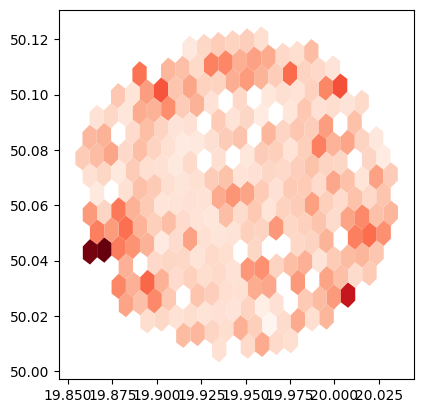

In [10]:
gdf_h3_krk.plot(column='time_mean', cmap='Reds')